In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Load the 49 Value Weighted industry portfolio returns. Limit the analysis to returns of the 49 VW portfolios from 1991 onwards (1991 included, 1990 not included, 2018 included). Also load the Fama French Research Factors over the same period. Use the Mkt-RF as in the lab notebooks to compute the CAPM betas.

#### Importing functions

In [6]:
def get_ind_file(filetype, weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios files
    Variant is a tuple of (weighting, size) where:
        weighting is one of "ew", "vw"
        number of inds is 30 or 49
    """    
    if filetype == "returns":
        name = f"{weighting}_rets" 
        divisor = 100
    elif filetype == "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype == "size":
        name = "size"
        divisor = 1
    else:
        raise ValueError(f"filetype must be one of: returns, nfirms, size")
    
    ind = pd.read_csv(f"data/ind{n_inds}_m_{name}.csv", header=0, index_col=0, na_values=-99.99)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_returns(weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios Monthly Returns
    """
    return get_ind_file("returns", weighting=weighting, n_inds=n_inds)

def get_ind_nfirms(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    return get_ind_file("nfirms", n_inds=n_inds)

def get_ind_size(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    return get_ind_file("size", n_inds=n_inds)


def get_ind_market_caps(n_inds=30, weights=False):
    """
    Load the industry portfolio data and derive the market caps
    """
    ind_nfirms = get_ind_nfirms(n_inds=n_inds)
    ind_size = get_ind_size(n_inds=n_inds)
    ind_mktcap = ind_nfirms * ind_size
    if weights:
        total_mktcap = ind_mktcap.sum(axis=1)
        ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
        return ind_capweight
    #else
    return ind_mktcap

def get_fff_returns():
    """
    Load the Fama-French Research Factor Monthly Dataset
    Mkt-Rf = market - risk free
    SMB = Small - Big
    HML = Hight - Low
    """
    rets = pd.read_csv("./data/F-F_Research_Data_Factors_m.csv",
                       header=0, index_col=0, na_values=-99.99)/100
    rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')
    return rets

In [10]:
fff_dataset = get_fff_returns()
fff_dataset = fff_dataset['1991':'2018']
print(fff_dataset.shape)
fff_dataset.head()

(336, 4)


,Mkt-RF,SMB,HML,RF
1991-01,0.0469,0.0379,-0.0184,0.0052
1991-02,0.0719,0.0395,-0.0054,0.0048
1991-03,0.0265,0.0389,-0.0123,0.0044
1991-04,-0.0028,0.0050,0.0142,0.0053
1991-05,0.0365,-0.0034,-0.0057,0.0047


In [13]:
ind49_rets = get_ind_returns(weighting="vw", n_inds=49)["1991":]
print(ind49_rets.shape)
ind49_rets.head()

(336, 49)


,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1991-01,0.0699,0.0312,0.0563,0.0465,0.0268,0.1191,0.0498,0.0936,0.0081,0.1821,...,0.1248,0.1230,0.0309,0.1174,0.0137,0.0823,0.0626,0.0312,0.0736,0.1240
1991-02,0.1038,0.1200,0.0751,0.1084,0.0768,0.1752,0.1019,0.0332,0.0639,0.1453,...,0.0523,0.0545,0.0849,0.0765,0.1331,0.1238,0.0918,0.1382,0.1155,0.0693
1991-03,0.0240,0.0612,0.0589,0.0567,0.0137,0.0439,-0.0231,0.0055,0.0414,0.0397,...,0.0826,-0.0194,0.0321,0.0935,0.1012,0.0481,0.0525,0.0827,0.0961,-0.0378
1991-04,-0.0071,-0.0084,-0.0188,-0.0401,-0.0347,0.0293,-0.0364,0.0301,-0.0144,0.0159,...,-0.0028,0.0363,0.0150,0.0263,-0.0240,0.0605,-0.0184,-0.0014,0.0094,-0.0010
1991-05,0.1075,0.0267,0.0310,0.0386,0.0394,0.0414,0.0393,0.0438,0.0405,0.0102,...,0.0505,0.0786,0.0659,0.0813,0.0484,0.0704,0.0260,-0.0234,0.0414,0.0407


$$ R_{brka,t} - R_{f,t} = \alpha + \beta(R_{mkt,t} - R_{f,t}) + \epsilon_t $$

<b>1. What is the CAPM (Single Factor) Beta when evaluated over the entire period (1991-2018) of Beer?</b>

Enter the answer as a number to at least two decimal places (e.g. 0.92)


##### creating suport dfs

In [49]:
beer_rets = ind49_rets['Beer']
beer_excess = beer_rets-fff_dataset['RF']
mkt_excess = pd.DataFrame(fff_dataset['Mkt-RF'])
exp_var_01 = mkt_excess.copy()
exp_var_01['Constant'] = 1

##### creating OLS Regression

In [20]:
import statsmodels.api as sm

In [50]:
lm_01 = sm.OLS(beer_excess, exp_var_01).fit()
lm_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     97.55
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           2.37e-20
Time:                        16:57:01   Log-Likelihood:                 596.94
No. Observations:                 336   AIC:                            -1190.
Df Residuals:                     334   BIC:                            -1182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5295      0.054      9.877      0.000       0.424       0.635
Constant       0.0043      0.002      1.892      0.059      -0.000       0.009
==============================================================================
Omnibus:                       20.697   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.130
Skew:                          -0.314   Prob(JB):                     4.31e-10
Kurtosis:                       4.639   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$$B_{beer}= Mkt-RF => 0.5295$$

<b>2.Using the same data as the previous question, what is the CAPM Beta when evaluated over the entire period (1991-2018) of Steel?</b>

Enter the answer as a number to at least two decimal places (e.g. 0.92)

In [47]:
steel_rets = ind49_rets['Steel']
steel_excess = steel_rets-fff_dataset['RF']
mkt_excess = pd.DataFrame(fff_dataset['Mkt-RF'])
exp_var_02 = mkt_excess.copy()
exp_var_02['Constant'] = 1

In [52]:
lm_02 = sm.OLS(steel_excess, exp_var_02).fit()
lm_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     572.0
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           2.29e-74
Time:                        16:58:14   Log-Likelihood:                 532.25
No. Observations:                 336   AIC:                            -1061.
Df Residuals:                     334   BIC:                            -1053.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.5546      0.065     23.917      0.000       1.427       1.682
Constant      -0.0055      0.003     -2.014      0.045      -0.011      -0.000
==============================================================================
Omnibus:                       24.614   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.413
Skew:                           0.456   Prob(JB):                     6.17e-10
Kurtosis:                       4.482   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$$B_{steel}= Mkt-RF => 1.55$$

<b>3.Using the same data as the previous question, what is the CAPM Beta when evaluated over the 2013-2018 (both included) period of Beer?</b>

Enter the answer as a number to at least two decimal places (e.g. 0.92)

In [81]:
beer_rets_03 = ind49_rets.loc['2013':'2018',['Beer']]
beer_excess_03 = beer_rets_03-fff_dataset.loc['2013':'2018', ['RF']].values
mkt_excess = pd.DataFrame(fff_dataset.loc['2013':'2018',['Mkt-RF']])
exp_var_03 = mkt_excess.copy()
exp_var_03['Constant'] = 1

In [80]:
lm_03 = sm.OLS(beer_excess_03, exp_var_03).fit()
lm_03.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Beer   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     31.87
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           3.27e-07
Time:                        17:06:34   Log-Likelihood:                 155.66
No. Observations:                  72   AIC:                            -307.3
Df Residuals:                      70   BIC:                            -302.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5860      0.104      5.645      0.000       0.379       0.793
Constant       0.0045      0.003      1.289      0.201      -0.002       0.011
==============================================================================
Omnibus:                        5.069   Durbin-Watson:                   2.196
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                4.535
Skew:                          -0.610   Prob(JB):                        0.104
Kurtosis:                       3.155   Cond. No.                         31.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$$B_{beer}= Mkt-RF => 0.586$$

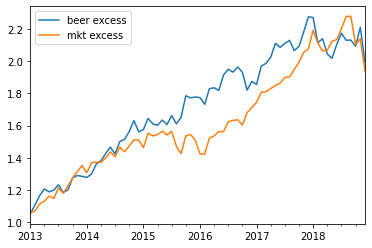

In [108]:
df_t = pd.DataFrame([], index = beer_excess.index)
df_t['beer excess'] = (beer_excess_03+1).cumprod()
df_t['mkt excess'] = (mkt_excess+1).cumprod()
df_t.plot()

<b>4.Using the same data set as the previous question, what is the CAPM Beta when evaluated over the 2013-2018 (both included) period of Steel?1</b>

Enter the answer as a number to at least two decimal places (e.g. 0.92)

In [103]:
steel_rets_04 = ind49_rets.loc['2013':'2018',['Steel']]
steel_excess_04 = steel_rets_04-fff_dataset.loc['2013':'2018', ['RF']].values
mkt_excess = pd.DataFrame(fff_dataset.loc['2013':'2018',['Mkt-RF']])
exp_var_04 = mkt_excess.copy()
exp_var_04['Constant'] = 1

In [114]:
lm_04 = sm.OLS(steel_excess_04, exp_var_04).fit()
lm_04.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Steel   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     62.18
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           2.97e-11
Time:                        17:21:23   Log-Likelihood:                 116.15
No. Observations:                  72   AIC:                            -228.3
Df Residuals:                      70   BIC:                            -223.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.4169      0.180      7.885      0.000       1.059       1.775
Constant      -0.0098      0.006     -1.627      0.108      -0.022       0.002
==============================================================================
Omnibus:                        7.128   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.420
Skew:                           0.635   Prob(JB):                       0.0403
Kurtosis:                       3.727   Cond. No.                         31.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
lm_04.params[0]

1.4169446523353808

$$B_{steel}= Mkt-RF => 1.4169$$

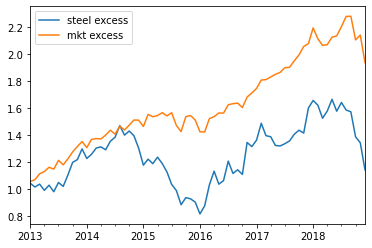

In [111]:
df_t = pd.DataFrame([], index = steel_excess_04.index)
df_t['steel excess'] = (steel_excess_04+1).cumprod()
df_t['mkt excess'] = (mkt_excess+1).cumprod()
df_t.plot()

In [143]:
steel_rets_04 = ind49_rets.loc['2013':'2018',['Steel']]
steel_excess_04 = steel_rets_04-fff_dataset.loc['2013':'2018', ['RF']].values
mkt_excess = pd.DataFrame(fff_dataset.loc['2013':'2018',['Mkt-RF']])
exp_var_04 = mkt_excess.copy()
exp_var_04['Constant'] = 1
lm_04 = sm.OLS(steel_excess_04, exp_var_04).fit()
lm_04.params[0]

1.4169446523353808

<b>5. Using the same data as the previous question, which of the 49 industries had the highest CAPM Beta when evaluated over the 1991-1993 (both included) period? (Use the same industry names as in the files). Enter the name as a text string, and remember to exactly match the column headers in the data file.</b>

### Automatic Creating and fetching values

In [159]:
ind49 = ind49_rets.columns
lm_b = []
mkt_excess = pd.DataFrame(fff_dataset.loc['1991':'1993',['Mkt-RF']])
exp_var_05 = mkt_excess.copy()
exp_var_05['Constant'] = 1

for i in ind49:
    
    exec('%s_rets_05 = ind49_rets.loc[\'1991\':\'1993\',[\'%s\']]' %(i,i))
    exec('%s_excess_05 = %s_rets_05-fff_dataset.loc[\'1991\':\'1993\', [\'RF\']].values' %(i,i))
    exec('lm_%s_05 = sm.OLS(%s_excess_05, exp_var_05).fit()' %(i,i))
    exec('lm_b.append(lm_%s_05.params[0])' %(i))



In [166]:
dict_ind_beta = {'industry': ind49,
              'beta': lm_b}
df_ind_beta= pd.DataFrame(dict_ind_beta)

1.6151954971134441

###### Max beta in the period

In [169]:
df_ind_beta[df_ind_beta['beta'] == df_ind_beta['beta'].max()]

,industry,beta
10,Hlth,1.615195


<b>6. Using the same data as the previous question, which of the 49 industries had the lowest CAPM Beta when evaluated over the 1991-1993 (both included) period? (Use the same industry names as in the files) . Enter the answer as text and remember to exactly match the column headers in the data file.</b>

###### min beta in the period

In [170]:
df_ind_beta[df_ind_beta['beta'] == df_ind_beta['beta'].min()]

,industry,beta
26,Gold,-0.553289


## For the next 4 questions use the Full 3 Factor Fama-French model using the research data supplied in the following data file:

F-F_Research_Data_Factors.csv

and the same 1991-2018 period you have just used for the previous questions.



<b>7. Of the 49 industries, which displayed the highest Small Cap tilt when analyzed over the entire 1991-2018 period?</b>

Enter your answer as a text string, and remember to use the exact same name as the column header in the text file

$$ R_{brka,t} - R_{f,t} = \alpha + \beta_{capm}(R_{mkt,t} - R_{f,t})+\beta_{smb}(SMB_t) +\beta{hml}(HML_t)+ \epsilon_t $$

In [175]:

steel_rets_04 = ind49_rets.loc['2013':'2018',['Steel']]
steel_excess_04 = steel_rets_04-fff_dataset.loc['2013':'2018', ['RF']].values
mkt_excess = pd.DataFrame(fff_dataset.loc['2013':'2018',['Mkt-RF']])
exp_var_04 = mkt_excess.copy()
exp_var_04['Constant'] = 1
exp_var_04['Value'] = fff_dataset.loc['2013':'2018',['HML']]
exp_var_04['Size'] = fff_dataset.loc['2013':'2018',['SMB']]

exp_var_04
lm_04 = sm.OLS(steel_excess_04, exp_var_04).fit()
#lm_04.params[0]
lm_04.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Steel   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     28.34
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           5.29e-12
Time:                        20:05:23   Log-Likelihood:                 122.46
No. Observations:                  72   AIC:                            -236.9
Df Residuals:                      68   BIC:                            -227.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.3607      0.173      7.849      0.000       1.015       1.707
Constant      -0.0076      0.006     -1.346      0.183      -0.019       0.004
Value          0.7771      0.239      3.246      0.002       0.299       1.255
Size           0.3155      0.230      1.369      0.175      -0.144       0.775
==============================================================================
Omnibus:                        1.796   Durbin-Watson:                   2.271
Prob(Omnibus):                  0.407   Jarque-Bera (JB):                1.420
Skew:                           0.343   Prob(JB):                        0.492
Kurtosis:                       3.042   Cond. No.                         46.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [178]:
ind49 = ind49_rets.columns

lm_b_capm = []
lm_b_value = []
lm_b_size = []

mkt_excess = pd.DataFrame(fff_dataset.loc['1991':'2018',['Mkt-RF']])
exp_var_07 = mkt_excess.copy()
exp_var_07['Constant'] = 1
exp_var_07['Value'] = fff_dataset.loc['1991':'2018',['HML']]
exp_var_07['Size'] = fff_dataset.loc['1991':'2018',['SMB']]

for i in ind49:
    
    exec('%s_rets_07 = ind49_rets.loc[\'1991\':\'2018\',[\'%s\']]' %(i,i))
    exec('%s_excess_07 = %s_rets_07-fff_dataset.loc[\'1991\':\'2018\', [\'RF\']].values' %(i,i))
    exec('lm_%s_07 = sm.OLS(%s_excess_07, exp_var_07).fit()' %(i,i))
    
    exec('lm_b_capm.append(lm_%s_07.params[0])' %(i))
    exec('lm_b_value.append(lm_%s_07.params[2])' %(i))
    exec('lm_b_size.append(lm_%s_07.params[3])' %(i))

In [182]:
dict_ind_beta_ff = {'industry': ind49,
                    'beta capm': lm_b_capm,
                    'beta value': lm_b_value,
                    'beta size': lm_b_size}
df_ind_beta_ff= pd.DataFrame(dict_ind_beta_ff)
df_ind_beta_ff

,industry,beta capm,beta value,beta size
0,Agric,0.684404,0.131897,0.165856
1,Food,0.558117,0.156536,-0.267873
2,Soda,0.817167,0.397642,-0.121587
3,Beer,0.590261,0.006329,-0.358655
4,Smoke,0.590791,0.266018,-0.307794
5,Toys,0.939820,0.423761,0.329862
6,Fun,1.326548,0.310497,0.281732
7,Books,1.025644,0.435918,0.137026
8,Hshld,0.646211,0.125855,-0.171127
9,Clths,1.011445,0.345496,0.057455


In [185]:
df_ind_beta_ff[df_ind_beta_ff['beta size'] ==df_ind_beta_ff['beta size'].max()]

,industry,beta capm,beta value,beta size
19,FabPr,1.046902,0.490916,0.688508


<b>8. Using the same dataset and period as the previous question, of the 49 industries, which displayed the highest Large Cap tilt when analyzed over the entire period? </b>

In [188]:
df_ind_beta_ff[df_ind_beta_ff['beta size'] ==df_ind_beta_ff['beta size'].min()]

,industry,beta capm,beta value,beta size
3,Beer,0.590261,0.006329,-0.358655


<b>9. Using the same data as period as the previous question, of the 49 industries, which displayed the highest Value tilt when analyzed over the entire period? </b>

In [190]:
df_ind_beta_ff[df_ind_beta_ff['beta value'] ==df_ind_beta_ff['beta value'].max()]

,industry,beta capm,beta value,beta size
15,Txtls,1.236172,0.98356,0.535961


<b>10. Using the same data set and period as the previous question, of the 49 industries, which displayed the highest Growth tilt when analyzed over the entire period?</b>

In [191]:
df_ind_beta_ff[df_ind_beta_ff['beta value'] ==df_ind_beta_ff['beta value'].min()]

,industry,beta capm,beta value,beta size
35,Softw,1.255132,-0.852422,0.0661
